# Book Recommender---Part 4(Collaborative Filtering with neighborhood methods)

In this part, I will use collaborative filtering with neigborhood methods to build books recommender system.Neighborhood methods are centered on computing the relationships between items or between users. The item-based approach evaluates a users's rating for an item based on ratings of 'neighboring' items by the same user. A item's neighbors are other items that tend to get similiar ratings when rated by the same user.A product’s neighbors are other products that tend to get similar ratings when rated by the same user. 
For example, consider the movie Saving Private Ryan. Its neighbors might include war movies, Spielberg movies, and Tom Hanks movies, among others. To predict a particular user’s rating for Saving Private Ryan, we would look for the movie’s nearest neighbors that this user actually rated. As Figure 1 illustrates, the user-oriented approach identifies like-minded users who can complement each other’s ratings. We will apply the same strategy on the book recommender.

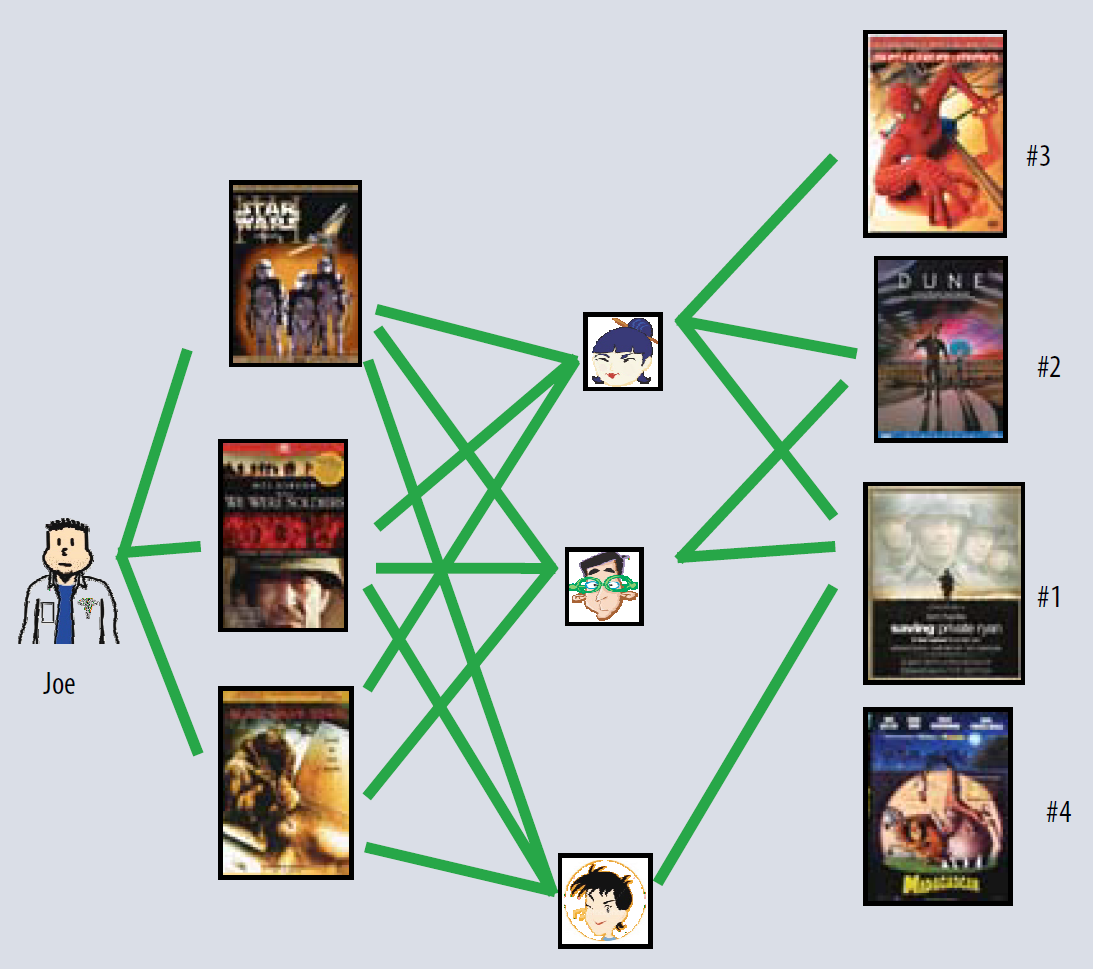

1) First, build a user_book_matrix M(U*B), U is the number of users, B is the number of books, matrix[i,j] refers to the rating the ith user rated the jth book.   

2) Then, decompose the user_book_matrix with SVD approach, 
$$M = USigmaV^T$$

3) Next, transform user_book_matrix into the lower-dimensional space matrix_recon, k is the number of concepts: 
$$M^{recon} = M^TU[:,:k]$$

4) Compute cosine similarity between books, for one user, use existing rating and similarity to forecast unknown rating. This approach called item_based collabrative filtering.(If we compute similarity between users, it called user_based collabrative filtering.)
$$r_{pred}=\frac{\sum_{i=1}^{n} r_iS_{ij}}{\sum_{i=1}^{n}S_{ij}}$$
$r_{pred}$ is the prediction of rating for unrated book, $r_i$ is the ith books the user has rated, n is the number of rated books

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import re
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from scipy import sparse


from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# 1. Construct user_book matrix and SVD 

In [2]:
books_df=pd.read_csv('./goodreads/books.csv')
books_df['bookID']=books_df['bookID'].astype('str')
books_df['authorID']=books_df['authorID'].astype('str')
ratings=pd.read_csv('./goodreads/final_ratings.csv')
ratings['bookID']=ratings['bookID'].astype('str')
ratings['userID']=ratings['userID'].astype('str')
ratings=ratings[ratings['bookID'].isin(books_df['bookID'])] # remove the books which is not in books_df
ratings['user_count']=ratings.groupby('userID')['userID'].transform('count') 
ratings=ratings[ratings['user_count']>=5] #only train the model to user who have rated no less than 5 books
userid_list=ratings['userID'].unique()

In [3]:
#split the data into train and test
train, test = train_test_split(ratings,
                               stratify=ratings['userID'], 
                               test_size=0.20,
                               random_state=42)

In [4]:
#create the idx to bookid dictionary and bookid to idx dictionary
idx_to_bookid=books_df['bookID'].to_dict()
bookid_to_idx={}
for k,v in idx_to_bookid.items():
    bookid_to_idx[v]=k
num_books=len(idx_to_bookid)
print(f"number of books={num_books}")

number of books=2970


In [5]:
#create the idx to userid dictionary and userid to idx dictionary
idx_to_userid=dict(enumerate(train['userID'].unique()))
userid_to_idx={}
for k,v in idx_to_userid.items():
    userid_to_idx[v]=k
num_users=len(idx_to_userid)
print(f"number of users={num_users}")

number of users=22981


In [6]:
#construct the user_book matrix and run SVD 
user_book_matrix=np.zeros((num_users,num_2books))
for _,row in train.iterrows():
    user_book_matrix[userid_to_idx[row['userID']],bookid_to_idx[row['bookID']]]=row['rating']

#SVD decompostion, U maps the users to latent concepts, V maps the books to latent concepts,S represesnt the strength of the latent concepts 
U, S, VT = np.linalg.svd(user_book_matrix)

In [7]:
#reconstruct the matrix, the each row of recon_matrix represents a book with a lower demension
k=10 
recon_matrix=(user_book_matrix.T).dot(U[:,:k])

In [8]:
#compute the similarity between rows(books)
recon_matrix = sparse.csr_matrix(recon_matrix)
similarities = cosine_similarity(recon_matrix)

# 2. Item_based prediction of ratings

In [9]:
#predict the rating for user whose id is '1742824'
rated_bookID = train.loc[train.userID =='1742824']['bookID'].values
rated_books=books_df[books_df['bookID'].isin(rated_bookID)]
unrated_books=books_df[~books_df['bookID'].isin(rated_bookID)]
rating_mapping=defaultdict(int)
sim_mapping=defaultdict(int)
rating_pred={}
for book_r_idx in rated_books.index:
    rating_r=rated_books[rated_books.index==book_r_idx]['rating'].values[0]    
    for book_ur_idx in unrated_books.index:   
        similar=similarities[book_r_idx,book_ur_idx]
        #print('similar',similar)
        rating_mapping[book_ur_idx]+=(rating_r*similar)
        sim_mapping[book_ur_idx]+=similar
for book_ur_idx in unrated_books.index:
    #print(book_ur_ID)
    #rating_p=rating_mapping[book_ur_idx]/sim_mapping[book_ur_idx]
    #if rating_p>5:rating_p=5
    #elif rating_p<0:rating_p=1
    rating_pred[book_ur_idx]=rating_mapping[book_ur_idx]/sim_mapping[book_ur_idx]
unrated_books['rating_pred']=pd.Series(rating_pred)
true_rating_test=test[test['userID']=='1742824'].merge(unrated_books,on='bookID')['rating_x']
pred_rating_test=test[test['userID']=='1742824'].merge(unrated_books,on='bookID')['rating_pred']
rmse_test=sqrt(mean_squared_error(true_rating_test,pred_rating_test))
rmse_test

1.1075943039840537

In [10]:
#For each user, predict the rating of the unrated books,and compute the average RMSE across the users
def compute_rating(train,test,sim_matrix,books_df,userid_list):
    rmse_train_list=[] 
    rmse_test_list=[]
    for userid in tqdm(userid_list,desc="computing rating"):
        rated_bookID = train.loc[train.userID ==userid]['bookID'].values
        rated_books=books_df[books_df['bookID'].isin(rated_bookID)]
        #unrated_books=books_df.loc[~books_df['bookID'].isin(rated_bookID)]['bookID'].values
        unrated_books=books_df[~books_df['bookID'].isin(rated_bookID)]
        rating_mapping=defaultdict(int)
        sim_mapping=defaultdict(int)
        rating_pred={}
        for book_r_idx in rated_books.index:
            rating_r=rated_books[rated_books.index==book_r_idx]['rating'].values[0]    
            for book_ur_idx in unrated_books.index:   
                similar=sim_matrix[book_r_idx,book_ur_idx]
                #print('similar',similar)
                rating_mapping[book_ur_idx]+=(rating_r*similar)
                sim_mapping[book_ur_idx]+=similar
        for book_ur_idx in unrated_books.index:
            #print(book_ur_ID)
            rating_p=rating_mapping[book_ur_idx]/sim_mapping[book_ur_idx]
            if rating_p>5:rating_p=5
            elif rating_p<1:rating_p=1
            rating_pred[book_ur_idx]=rating_p
        unrated_books['rating_pred']=pd.Series(rating_pred)
        true_rating_test=test[test['userID']==userid].merge(unrated_books,on='bookID')['rating_x']        
        pred_rating_test=test[test['userID']==userid].merge(unrated_books,on='bookID')['rating_pred']
        if len(true_rating_test)==0 or len(pred_rating_test)==0: continue
        pred_rating_test=pred_rating_test.fillna(0)
        #print(pred_rating_test)
        rmse_test=sqrt(mean_squared_error(true_rating_test,pred_rating_test))
        rmse_test_list.append(rmse_test)       
    print(f'The mean rmse of rating prediction for test dataset is {np.mean(rmse_test_list)}')
    return np.mean(rmse_test_list)

In [11]:
compute_rating(train,test,similarities,books_df,userid_list)


The mean rmse of rating prediction for test dataset is 0.922276916418873


0.922276916418873

# 3. Recommend top N books for a user 

In [12]:
def recommend_books(sim_matrix,ratings,books_df,userid,N=10):
    rated_bookID = ratings.loc[ratings.userID ==userid]['bookID'].values
    rated_books=books_df[books_df['bookID'].isin(rated_bookID)]
    unrated_books=books_df[~books_df['bookID'].isin(rated_bookID)]
    rating_mapping=defaultdict(int)
    sim_mapping=defaultdict(int)
    rating_pred={}
    for idx_r in rated_books.index:
        rating_r=rated_books[rated_books.index==idx_r]['rating'].values[0]
        for idx_ur in unrated_books.index:
            similarity=sim_matrix[idx_r,idx_ur]
            rating_mapping[idx_ur]+=(rating_r*similarity)
            sim_mapping[idx_ur]+=similarity
    for idx_ur in unrated_books.index:
        rating_pred[idx_ur]=(rating_mapping[idx_ur]/sim_mapping[idx_ur])
    unrated_books['rating_pred']=pd.Series(rating_pred)
    return unrated_books.sort_values('rating_pred',ascending=False).head(N)[['title','rating','rating_pred']]

In [13]:
#recommend 10 books for user whose id is '2745288'
recommend_books(similarities,ratings,books_df,userid='2745288',N=10)

,title,rating,rating_pred
1274,Avaland,4.72,4.150970
1057,Leap of Faith (The Rufino Factor Book One),4.24,4.132800
2366,The Zenia Wood,4.43,4.107692
2306,The Medallion,4.41,4.106947
2906,Narmada,3.90,4.085794
1442,Gray Hawk of Terrapin,4.37,4.083015
2294,Collide,4.21,4.080526
1437,The City of Light,4.40,4.067289
1735,Ellipsis,4.42,4.064432
2864,El mañana del fin: Máxima profeta (El mañana d...,3.57,4.062632
